# SETUP IMPORTS

In [ ]:
from monai.utils import first
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandFlipd,
    Spacingd,
    Invertd,
    NormalizeIntensityd,
    ResizeWithPadOrCropd,
    RandSpatialCropd,
    SpatialPadd,
    SaveImaged,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.nets import UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from sklearn.model_selection import KFold
import torch
import matplotlib.pyplot as plt
import tempfile
import os
import tempfile
import nibabel as nib

In [23]:
model_name = "bigger_patch_dh"

## Setup data directory

In [ ]:
os.environ["MONAI_DATA_DIRECTORY"] = "/cluster/home/giorgime/mini-project/MONAI_DATA_DIRECTORY"
# Codice di gestione della directory
directory = os.environ.get("MONAI_DATA_DIRECTORY") + "/" + model_name
if directory is not None:
    os.makedirs(directory, exist_ok=True) 
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"Dati salvati in: {root_dir}")

Dati salvati in: /cluster/home/giorgime/mini-project/MONAI_DATA_DIRECTORY/bigger_patch_dh


## Extract the Dataset

In [4]:
data_directory = "dataset/train"
subjects = os.listdir(data_directory)

data = []
for subj in subjects:
    preRT_img = os.path.join(data_directory, subj, "preRT", f"{subj}_preRT_T2.nii.gz")
    preRT_mask = os.path.join(data_directory, subj, "preRT", f"{subj}_preRT_mask.nii.gz")
    
    if os.path.exists(preRT_img) and os.path.exists(preRT_mask):
        data.append({"image": preRT_img, "label": preRT_mask})
print(data)

[{'image': 'dataset/train/50/preRT/50_preRT_T2.nii.gz', 'label': 'dataset/train/50/preRT/50_preRT_mask.nii.gz'}, {'image': 'dataset/train/46/preRT/46_preRT_T2.nii.gz', 'label': 'dataset/train/46/preRT/46_preRT_mask.nii.gz'}, {'image': 'dataset/train/75/preRT/75_preRT_T2.nii.gz', 'label': 'dataset/train/75/preRT/75_preRT_mask.nii.gz'}, {'image': 'dataset/train/119/preRT/119_preRT_T2.nii.gz', 'label': 'dataset/train/119/preRT/119_preRT_mask.nii.gz'}, {'image': 'dataset/train/11/preRT/11_preRT_T2.nii.gz', 'label': 'dataset/train/11/preRT/11_preRT_mask.nii.gz'}, {'image': 'dataset/train/195/preRT/195_preRT_T2.nii.gz', 'label': 'dataset/train/195/preRT/195_preRT_mask.nii.gz'}, {'image': 'dataset/train/80/preRT/80_preRT_T2.nii.gz', 'label': 'dataset/train/80/preRT/80_preRT_mask.nii.gz'}, {'image': 'dataset/train/63/preRT/63_preRT_T2.nii.gz', 'label': 'dataset/train/63/preRT/63_preRT_mask.nii.gz'}, {'image': 'dataset/train/188/preRT/188_preRT_T2.nii.gz', 'label': 'dataset/train/188/preRT/188_

## Define Transformations

In [ ]:
patch_size = (160, 160, 64)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        NormalizeIntensityd(
            keys=["image"],
            nonzero=True,
            channel_wise=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,
            pos=10,
            neg=10,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        NormalizeIntensityd(
            keys=["image"],
            nonzero=True,
            channel_wise=False
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    ]
)

In [6]:
train_files, val_files = data[:-10], data[-10:]

## Check transforms

### Train transformation

image shape: torch.Size([160, 160, 64]), label shape: torch.Size([160, 160, 64])


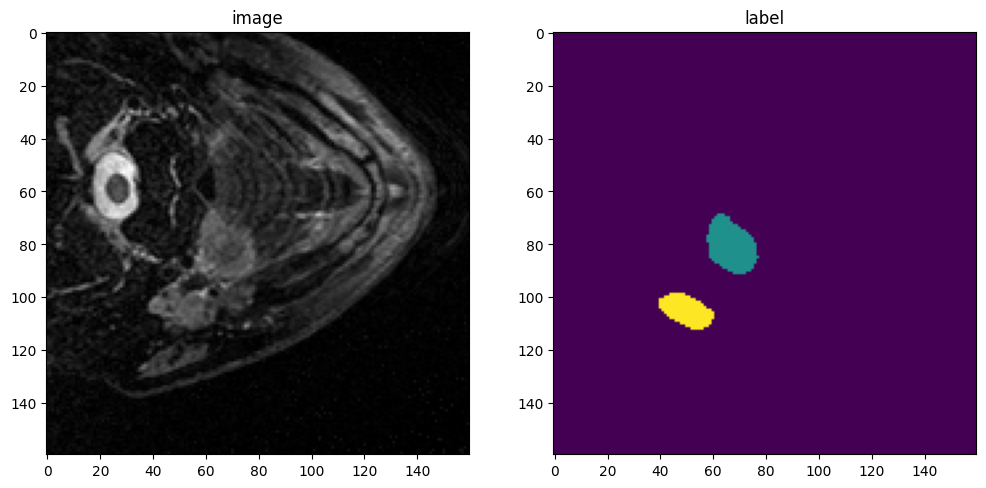

In [70]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
slice_idx = 50
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice_idx])
plt.show()

### Validation tranformation

image shape: torch.Size([255, 250, 147]), label shape: torch.Size([255, 250, 147])


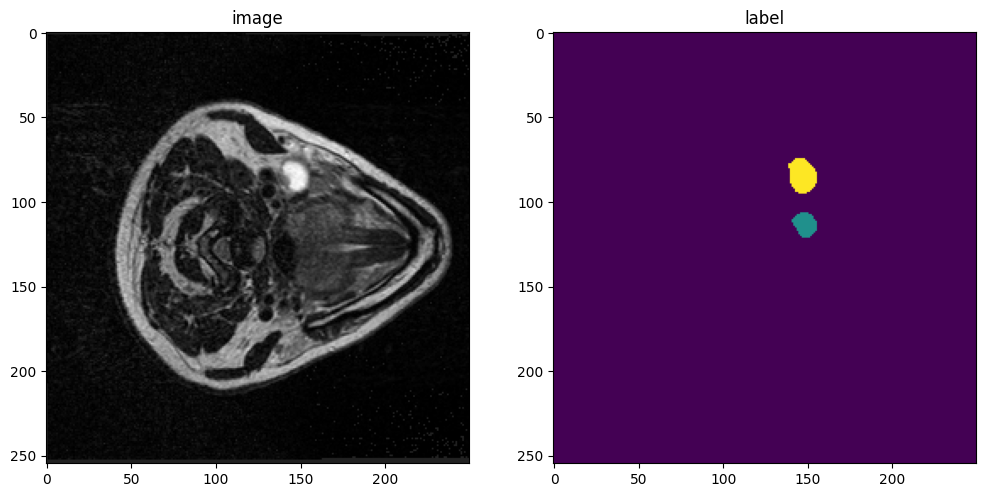

In [67]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
slice_idx = 70
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, slice_idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, slice_idx])
plt.show()

In [9]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    print(f"\n{'=' * 20} Fold {fold + 1} / {k_folds} {'=' * 20}")
    
    train_files = [data[i] for i in train_idx]
    val_files = [data[i] for i in val_idx]

    train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

    val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)


==================== Fold 1 / 5 ====================


Loading dataset:   0%|          | 0/104 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 104/104 [02:39<00:00,  1.54s/it]
/cluster/home/giorgime/.conda/envs/env_dl_gm/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loading dataset: 100%|██████████| 26/26 [00:39<00:00,  1.50s/it]



==================== Fold 2 / 5 ====================


Loading dataset: 100%|██████████| 26/26 [00:38<00:00,  1.47s/it]



==================== Fold 3 / 5 ====================


Loading dataset: 100%|██████████| 26/26 [00:39<00:00,  1.52s/it]



==================== Fold 4 / 5 ====================


Loading dataset: 100%|██████████| 26/26 [00:41<00:00,  1.60s/it]



==================== Fold 5 / 5 ====================


Loading dataset: 100%|██████████| 26/26 [00:39<00:00,  1.52s/it]


# Definition of the Model

In [10]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
model.to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Using 2 GPUs


# Training Loop

In [11]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=os.path.join(root_dir, "logs"))

In [12]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=3)])
post_label = Compose([AsDiscrete(to_onehot=3)])


for epoch in range(max_epochs):
    print(f"--- Epoch {epoch + 1}/{max_epochs} ---")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    writer.add_scalar("train/loss", epoch_loss, epoch)
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = sliding_window_inference(val_inputs, patch_size, 4, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()

            print(f"Validation Dice: {metric:.4f}")
            writer.add_scalar("val/dice", metric, epoch)
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                model_path = os.path.join(root_dir, "best_metric_model.pth")
                torch.save(model.state_dict(), model_path)
                print(f"Saved best model for fold {fold + 1} at epoch {best_metric_epoch} with dice {best_metric:.4f}")

    torch.save(model.state_dict(), os.path.join(root_dir, "last_model.pth"))
    print(f"Saved last epoch model with dice {best_metric:.4f}")
print(f"Fold {fold + 1} completed. Best Dice: {best_metric:.4f} at epoch {best_metric_epoch}")

--- Epoch 1/600 ---


Epoch 1 average loss: 0.8175
Saved last epoch model with dice -1.0000
--- Epoch 2/600 ---
Epoch 2 average loss: 0.7942
Validation Dice: 0.0053
Saved best model for fold 5 at epoch 2 with dice 0.0053
Saved last epoch model with dice 0.0053
--- Epoch 3/600 ---
Epoch 3 average loss: 0.7725
Saved last epoch model with dice 0.0053
--- Epoch 4/600 ---
Epoch 4 average loss: 0.7517
Validation Dice: 0.0050
Saved last epoch model with dice 0.0053
--- Epoch 5/600 ---
Epoch 5 average loss: 0.7367
Saved last epoch model with dice 0.0053
--- Epoch 6/600 ---
Epoch 6 average loss: 0.7246
Validation Dice: 0.0091
Saved best model for fold 5 at epoch 6 with dice 0.0091
Saved last epoch model with dice 0.0091
--- Epoch 7/600 ---
Epoch 7 average loss: 0.7142
Saved last epoch model with dice 0.0091
--- Epoch 8/600 ---
Epoch 8 average loss: 0.7012
Validation Dice: 0.0338
Saved best model for fold 5 at epoch 8 with dice 0.0338
Saved last epoch model with dice 0.0338
--- Epoch 9/600 ---
Epoch 9 average loss: 0

In [13]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.4688 at epoch: 64


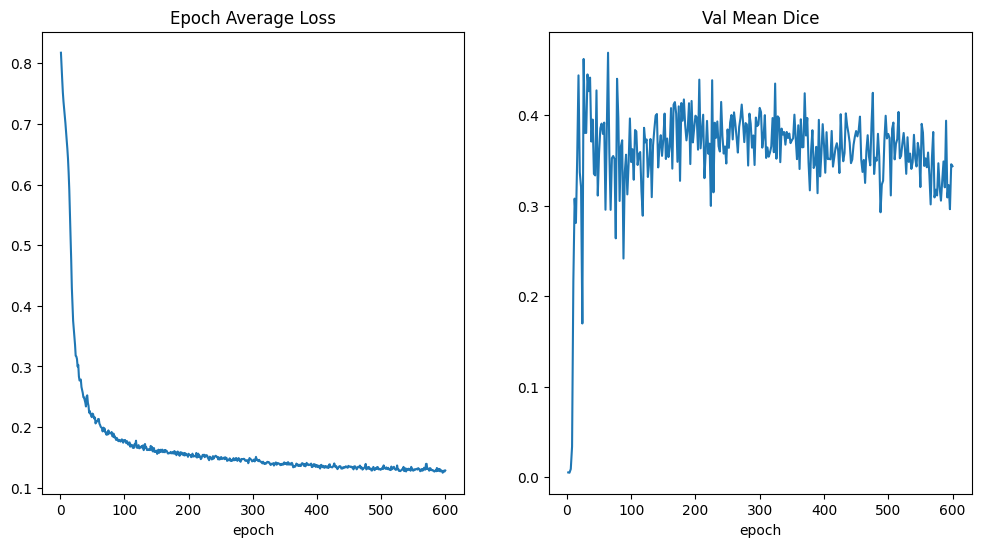

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

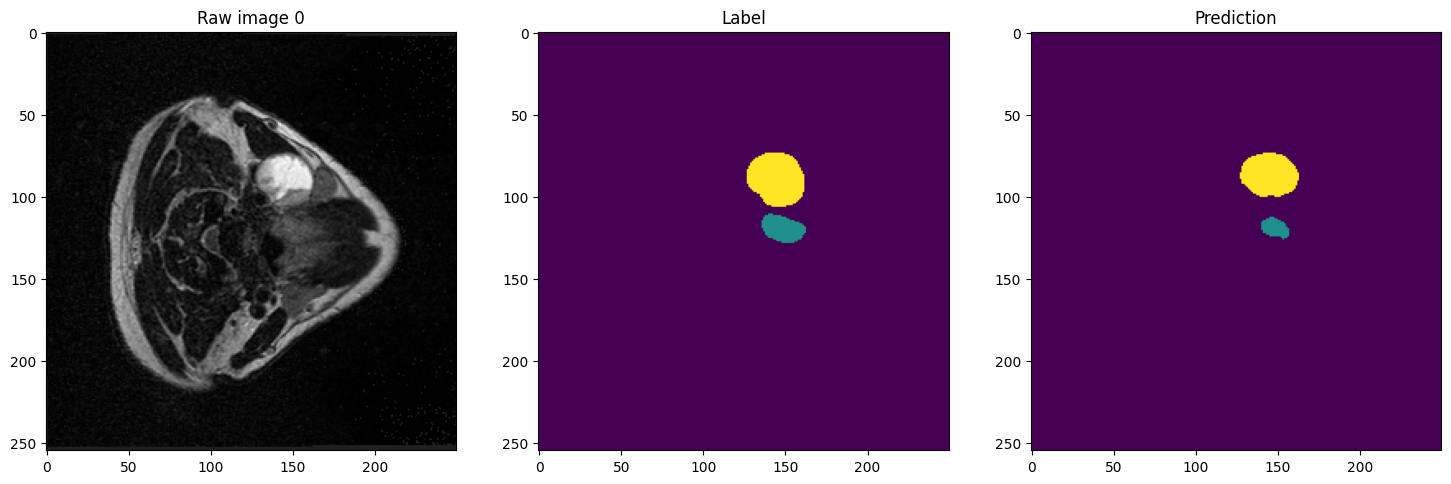

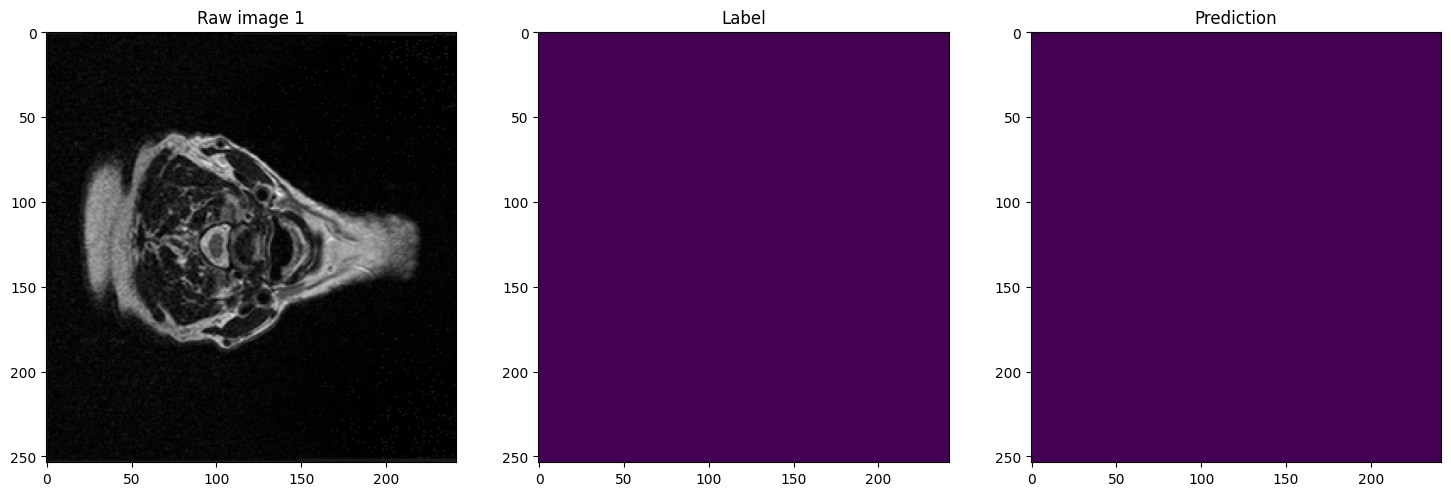

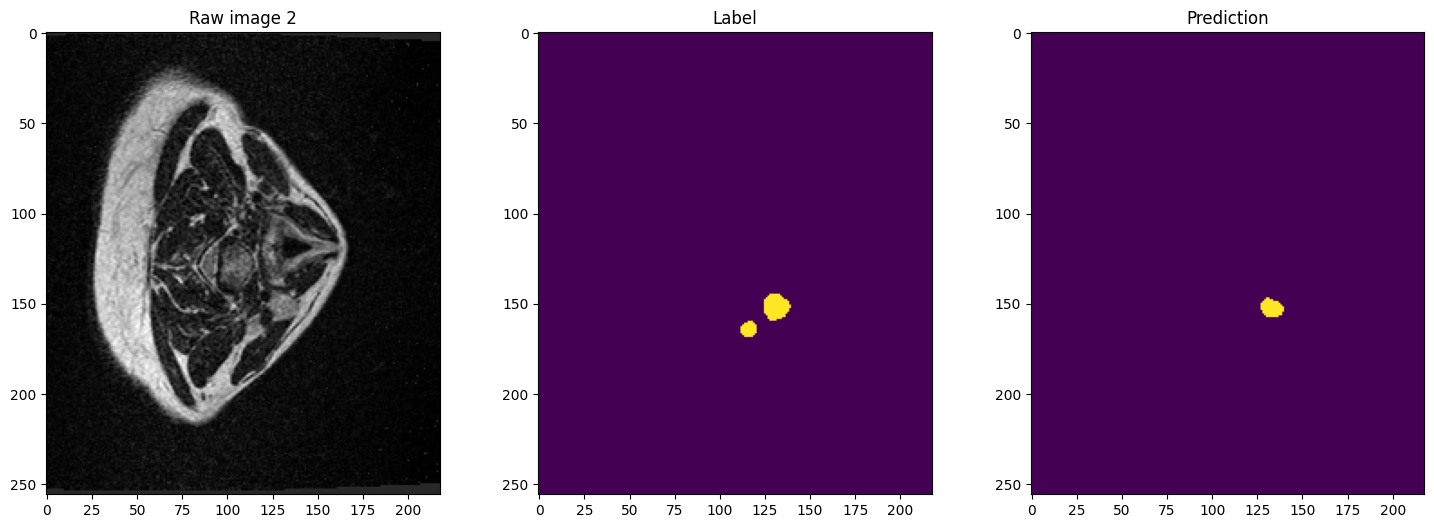

In [28]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), patch_size, sw_batch_size, model)
        slice_idx = 50
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"Raw image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, slice_idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"Label")
        plt.imshow(val_data["label"][0, 0, :, :, slice_idx])
        plt.subplot(1, 3, 3)
        plt.title(f"Prediction")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx])
        plt.show()
        if i == 2:
            break

## Inference on Test Set

In [82]:
data_directory = "dataset/test"
subjects = os.listdir(data_directory)

data_test = []
for subj in subjects:
    preRT_img = os.path.join(data_directory, subj, "preRT", f"{subj}_preRT_T2.nii.gz")
    preRT_mask = os.path.join(data_directory, subj, "preRT", f"{subj}_preRT_mask.nii.gz")
    
    if os.path.exists(preRT_img) and os.path.exists(preRT_mask):
        data_test.append({"image": preRT_img, "label": preRT_mask})
print(data_test)

[{'image': 'dataset/test/145/preRT/145_preRT_T2.nii.gz', 'label': 'dataset/test/145/preRT/145_preRT_mask.nii.gz'}, {'image': 'dataset/test/108/preRT/108_preRT_T2.nii.gz', 'label': 'dataset/test/108/preRT/108_preRT_mask.nii.gz'}, {'image': 'dataset/test/29/preRT/29_preRT_T2.nii.gz', 'label': 'dataset/test/29/preRT/29_preRT_mask.nii.gz'}, {'image': 'dataset/test/36/preRT/36_preRT_T2.nii.gz', 'label': 'dataset/test/36/preRT/36_preRT_mask.nii.gz'}, {'image': 'dataset/test/88/preRT/88_preRT_T2.nii.gz', 'label': 'dataset/test/88/preRT/88_preRT_mask.nii.gz'}, {'image': 'dataset/test/154/preRT/154_preRT_T2.nii.gz', 'label': 'dataset/test/154/preRT/154_preRT_mask.nii.gz'}, {'image': 'dataset/test/41/preRT/41_preRT_T2.nii.gz', 'label': 'dataset/test/41/preRT/41_preRT_mask.nii.gz'}, {'image': 'dataset/test/20/preRT/20_preRT_T2.nii.gz', 'label': 'dataset/test/20/preRT/20_preRT_mask.nii.gz'}, {'image': 'dataset/test/113/preRT/113_preRT_T2.nii.gz', 'label': 'dataset/test/113/preRT/113_preRT_mask.nii

In [83]:
test_data = [{"image": item["image"], "label": item["label"]} for item in data_test]

In [84]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(
            keys=["image"],
            nonzero=True,
            channel_wise=False
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

In [85]:
test_ds = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

post_transforms_test = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=3),
        AsDiscreted(keys="label", to_onehot=3),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [88]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
patch_size = (256, 256, 96)
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = patch_size
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)
        test_data = [post_transforms_test(i) for i in decollate_batch(test_data)]
        test_outputs, test_labels = from_engine(["pred", "label"])(test_data)
        dice_metric(y_pred=test_outputs, y=test_labels)

    test_dice = dice_metric.aggregate().item()
    dice_metric.reset()

print("Dice Metric on test set:", round(test_dice, 4))

2025-04-16 18:18:58,930 INFO image_writer.py:197 - writing: out/145_preRT_T2/145_preRT_T2_seg.nii.gz
2025-04-16 18:19:04,704 INFO image_writer.py:197 - writing: out/108_preRT_T2/108_preRT_T2_seg.nii.gz
2025-04-16 18:19:10,460 INFO image_writer.py:197 - writing: out/29_preRT_T2/29_preRT_T2_seg.nii.gz
2025-04-16 18:19:15,401 INFO image_writer.py:197 - writing: out/36_preRT_T2/36_preRT_T2_seg.nii.gz
2025-04-16 18:19:20,558 INFO image_writer.py:197 - writing: out/88_preRT_T2/88_preRT_T2_seg.nii.gz
2025-04-16 18:19:26,336 INFO image_writer.py:197 - writing: out/154_preRT_T2/154_preRT_T2_seg.nii.gz
2025-04-16 18:19:31,893 INFO image_writer.py:197 - writing: out/41_preRT_T2/41_preRT_T2_seg.nii.gz
2025-04-16 18:19:37,131 INFO image_writer.py:197 - writing: out/20_preRT_T2/20_preRT_T2_seg.nii.gz
2025-04-16 18:19:43,558 INFO image_writer.py:197 - writing: out/113_preRT_T2/113_preRT_T2_seg.nii.gz
2025-04-16 18:19:48,741 INFO image_writer.py:197 - writing: out/8_preRT_T2/8_preRT_T2_seg.nii.gz
2025

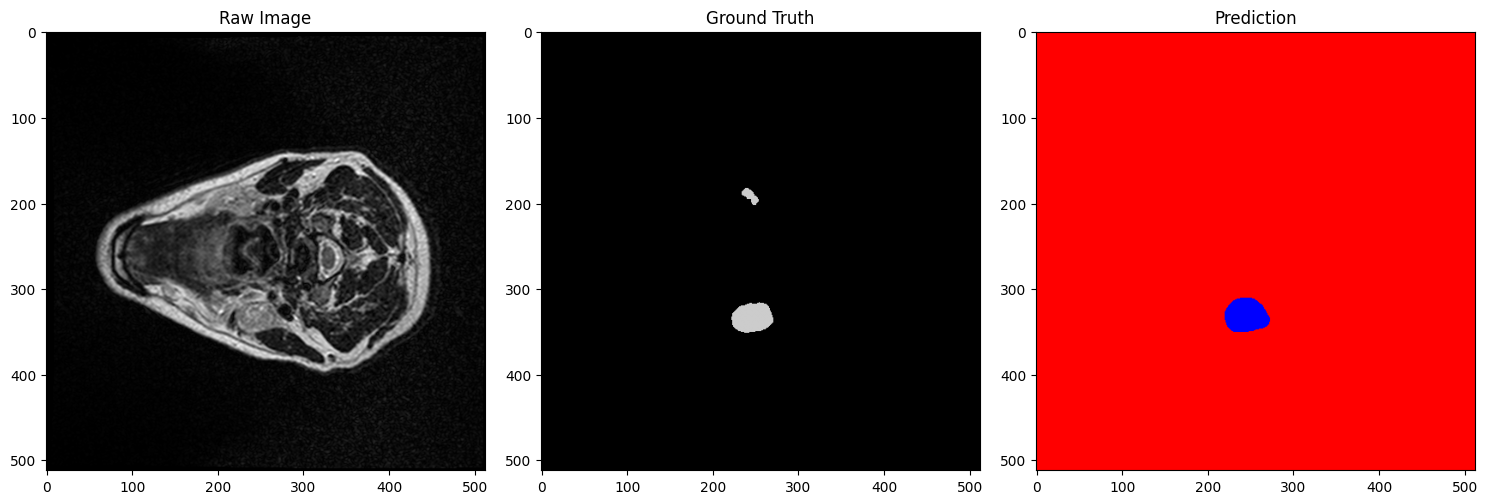

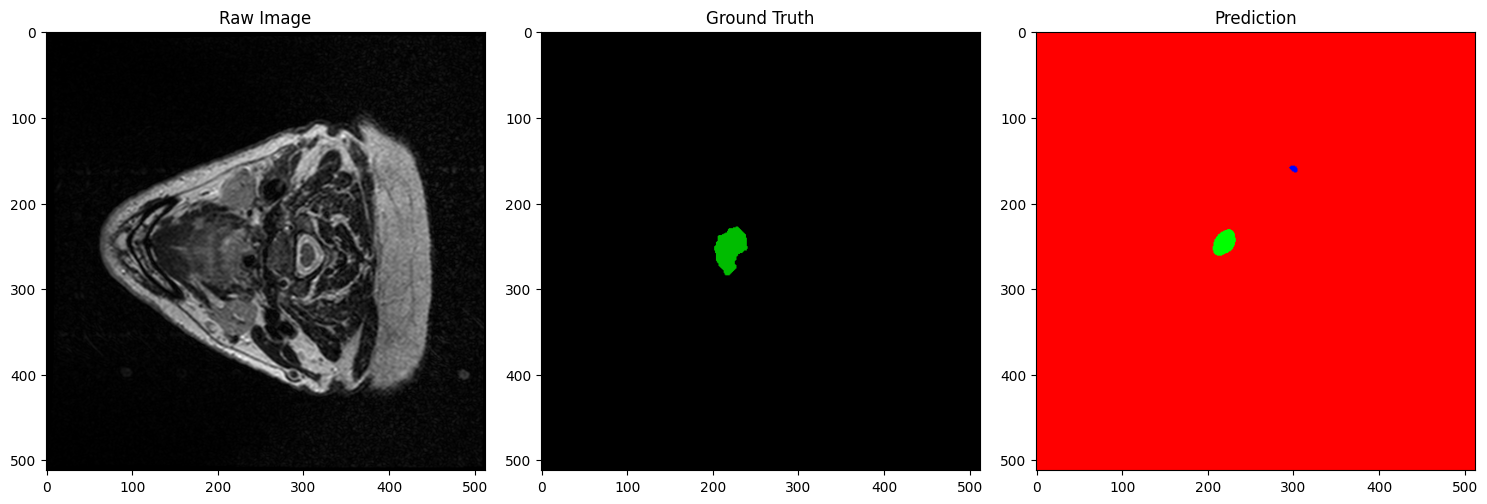

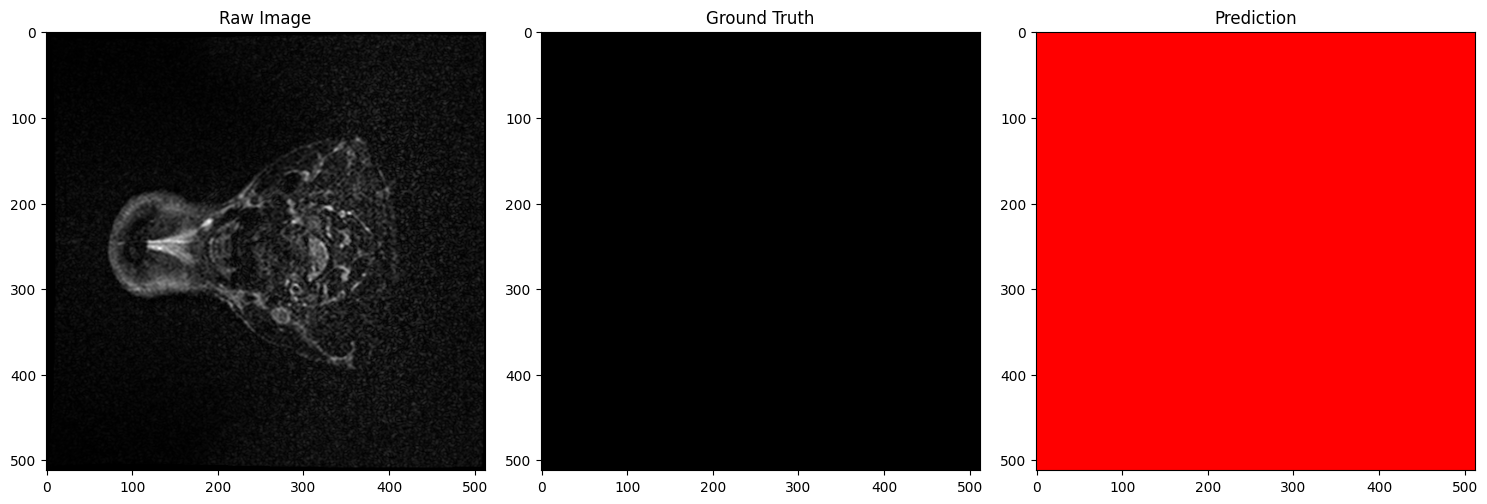

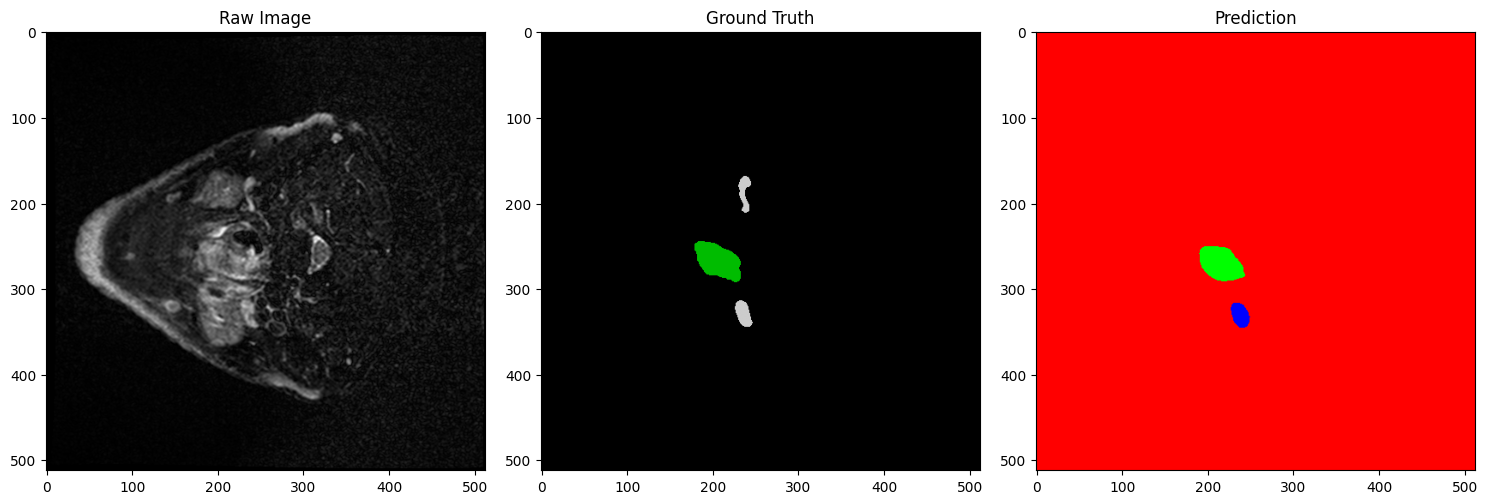

In [89]:
def show_prediction(imm, ground_truth_data, predicted_data, slice_idx):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(imm[:, :, slice_idx], cmap="gray")
    axs[0].set_title("Raw Image")
    axs[1].imshow(ground_truth_data[:, :, slice_idx], cmap="nipy_spectral", vmin=0, vmax=2)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(predicted_data[:, :, slice_idx], cmap="gray")
    axs[2].set_title("Prediction")
    plt.tight_layout()
    plt.show()

test_numnbers = [8, 20, 29, 36]#, 41, 42, 49, 82, 88, 91, 104, 105, 108, 113, 125, 135, 138, 145, 154, 158]
for test_number in test_numnbers:
    imm = nib.load(f"dataset/test/{test_number}/preRT/{test_number}_preRT_T2.nii.gz")
    imm = imm.get_fdata()
    ground_truth_img = nib.load(f"dataset/test/{test_number}/preRT/{test_number}_preRT_mask.nii.gz")
    ground_truth_data = ground_truth_img.get_fdata()
    predicted_img = nib.load(f"out/{test_number}_preRT_T2/{test_number}_preRT_T2_seg.nii.gz")
    predicted_data = predicted_img.get_fdata()
    show_prediction(imm, ground_truth_data, predicted_data, slice_idx=30)